# **Bidirectional Long Short Term Memory**

## **Setup**

In [1]:
import sys 
assert sys.version_info >= (3, 5) 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import matplotlib.cm as cm 
%matplotlib inline 
import seaborn as sns 

import sklearn 
assert sklearn.__version__ >= "0.20"
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import keras 
from keras.datasets import mnist
from keras.utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, GlobalMaxPooling1D
from keras.layers import SimpleRNN, Bidirectional, LSTM, Reshape, BatchNormalization
from keras import Input 
from scikeras.wrappers import KerasClassifier
from keras.optimizers import Adam, SGD, RMSprop

In [2]:
import os

current_directory = os.getcwd()
print("Current Directory:", current_directory)

if not current_directory.endswith('/Handwritten-digit-recognition'):
    path_parts = current_directory.split(os.sep)

    for i in range(len(path_parts), 0, -1):
        if path_parts[i - 1] == 'Handwritten-digit-recognition':
            new_directory = os.sep.join(path_parts[:i])
            os.chdir(new_directory)
            break
    else:
        print("Directory 'Handwritten-digit-recognition' not found in the current path.")
else:
    print("Already in the correct directory.")

print("New Directory:", os.getcwd())


Current Directory: c:\Users\ASUS\OneDrive\Desktop\Handwritten-digit-recognition\Src
New Directory: c:\Users\ASUS\OneDrive\Desktop\Handwritten-digit-recognition


In [3]:
# Where to save the figures 
PROJECT_ROOT_DIR = "."
FOLDER_ID = "handwritten digit recognition"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", FOLDER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure" , fig_id)
    if tight_layout: 
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## **Data preparation**

### **Load dataset**

In [4]:
train = pd.read_csv('datasets/digit-recognizer/train.csv')
test = pd.read_csv('datasets/digit-recognizer/test.csv')
sub = pd.read_csv('datasets/digit-recognizer/sample_submission.csv')

print("Loading data successful!!")

Loading data successful!!


### **Load more data sets**

In [5]:
(x_train1, y_train1), (x_test1, y_test1) = mnist.load_data()

x_train1 = np.concatenate([x_train1, x_test1], axis=0)
y_train1 = np.concatenate([y_train1, y_test1], axis=0)

X_train1 = x_train1.reshape(-1, 28*28)
Y_train1 = y_train1
Y_train1.shape, X_train1.shape
train1 = pd.DataFrame(np.column_stack((Y_train1, X_train1)), columns=train.columns)

In [6]:
# Merging all the data we got 
train = pd.DataFrame(np.concatenate((train, train1)), columns = train.columns)

In [7]:
X_train = train.drop(labels=["label"], axis=1)
Y_train = train["label"]

### **Normalization**

In [8]:
# Normalize data to make CNN faster 
X_train = X_train / 255.0
test = test / 255.0

In [9]:
X_train = X_train.values.reshape(-1, 28, 28)
test = test.values.reshape(-1, 28, 28)

In [10]:
# Convert label to one hot vectors (eg: 1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0])
Y_train = to_categorical(Y_train, num_classes=10)

*Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors **(ex : 1 -> [0,1,0,0,0,0,0,0,0,0])**.*

In [11]:
Y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## **Define the model**

### **Split training and validation set**

In [12]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=42)

In [13]:
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((100800, 28, 28), (11200, 28, 28), (100800, 10), (11200, 10))

In [14]:
def create_bi_lstm_model(activation='relu', optimizer='adam', learning_rate=0.001):
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
        
    model = Sequential([
        Input(shape=(28, 28)),
        Bidirectional(LSTM(128, activation=activation)),
        Dropout(0.5),
        Dense(128, activation=activation),
        Dropout(0.5),
        BatchNormalization(),
        Dense(10, activation='softmax')
    ])
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model 

In [15]:
# Create a KerasClassifier wrapper for Scikit-learn
batch_size = 64
epochs = 10
bi_lstm = KerasClassifier(build_fn=create_bi_lstm_model, epochs=epochs, batch_size=batch_size, verbose=0)

In [16]:
# Define the hyperparameters to tune
param_grid = {
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'model__activation': ['relu', 'tanh', 'sigmoid'],
    'model__learning_rate': [0.001, 0.005, 0.01]
}

### **Hyperparameter tuning using GridSearchCV**

In [17]:
# import warnings
# warnings.filterwarnings('ignore')

# # Use GridSearchCV to find the best combination of hyperparameters
# grid = GridSearchCV(estimator=bi_lstm, param_grid=param_grid, cv=3, verbose=2)
# grid_result = grid.fit(X_train, Y_train)

# Best Parameters: {'model__activation': 'tanh', 'model__learning_rate': 0.001, 'optimizer': 'sgd'}
# Best Accuracy: 0.9907638888888889

In [18]:
# # Display the best hyperparameters and corresponding accuracy
# print(f"Best Parameters: {grid_result.best_params_}")
# print(f"Best Accuracy: {grid_result.best_score_}")

# Best Parameters: {'model__activation': 'tanh', 'model__learning_rate': 0.001, 'optimizer': 'sgd'}
# Best Accuracy: 0.9907638888888889


In [19]:
bi_lstm = create_bi_lstm_model(optimizer='sgd', learning_rate=0.001, activation='tanh')

In [20]:
bi_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 256)            │       160,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 195,466 (763.54 KB)

 Trainable params: 195,210 (762.54 KB)

 Non-trainable params: 256 (1.00 KB)

In [21]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="FinalModels/BiLSTM.keras",
        monitor='val_loss',
        save_best_only=True,
        verbose=1),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=5, 
        verbose=1),
]

In [22]:
H = bi_lstm.fit(
    X_train, 
    Y_train, 
    validation_data=(X_val, Y_val),
    batch_size=batch_size, 
    epochs=epochs, 
    verbose=1, 
    callbacks=callbacks
)


Epoch 1/10
1574/1575 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2564 - loss: 2.3001
Epoch 1: val_loss improved from inf to 1.20398, saving model to FinalModels/BiLSTM.keras
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step - accuracy: 0.2566 - loss: 2.2996 - val_accuracy: 0.6246 - val_loss: 1.2040
Epoch 2/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5132 - loss: 1.4523
Epoch 2: val_loss improved from 1.20398 to 0.95163, saving model to FinalModels/BiLSTM.keras
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.5133 - loss: 1.4522 - val_accuracy: 0.7046 - val_loss: 0.9516
Epoch 3/10
1574/1575 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6026 - loss: 1.1913
Epoch 3: val_loss improved from 0.95163 to 0.82723, saving model to FinalModels/BiLSTM.keras
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 55s 35ms/step - accuracy: 0.6026 - loss: 1.1913 - val_accuracy: 0.7433 - val_loss: 0.8272
Epoch 4/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6543 - loss: 1.0346
Epoch 

Saving figure Final BiLSTM History image


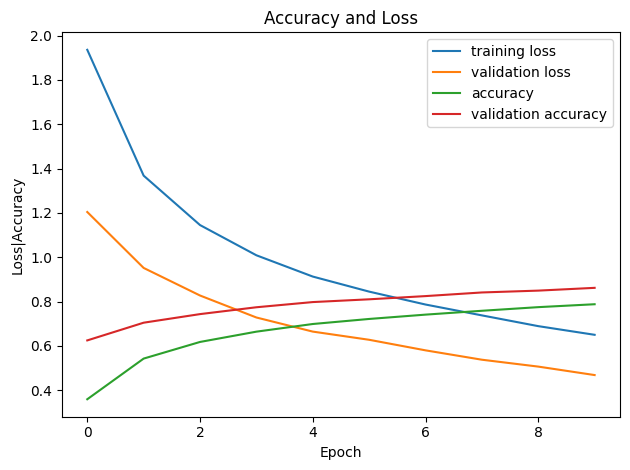

In [23]:
fig = plt.figure()
numOfEpoch = 10
plt.plot(np.arange(0, numOfEpoch), H.history['loss'], label='training loss')
plt.plot(np.arange(0, numOfEpoch), H.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, numOfEpoch), H.history['accuracy'], label='accuracy')
plt.plot(np.arange(0, numOfEpoch), H.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()
save_fig('Final BiLSTM History image')

## **Load the model**

In [24]:
bi_lstm = keras.saving.load_model("FinalModels/BiLSTM.keras")

### **Predict some examples**

In [25]:
predictions = bi_lstm.predict(test)

875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


Predictions:  2


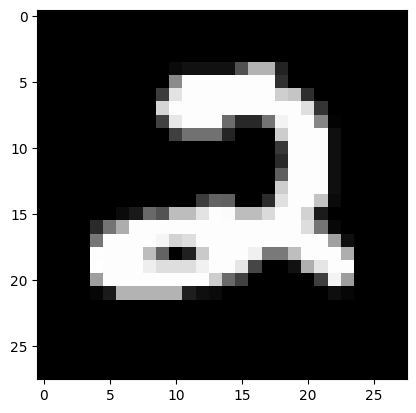

Predictions:  9


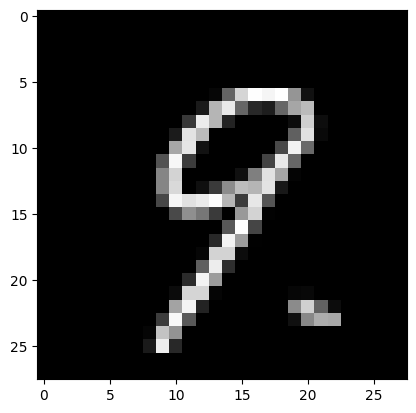

Predictions:  2


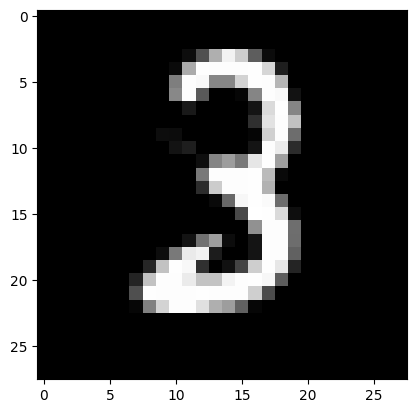

Predictions:  0


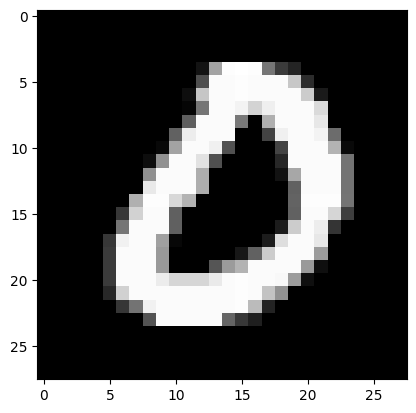

Predictions:  0


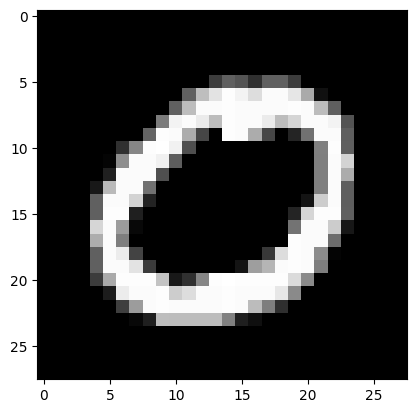

Predictions:  5


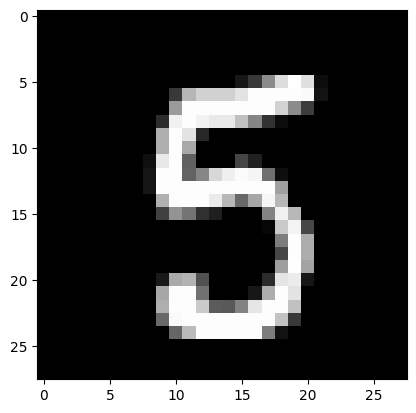

Predictions:  4


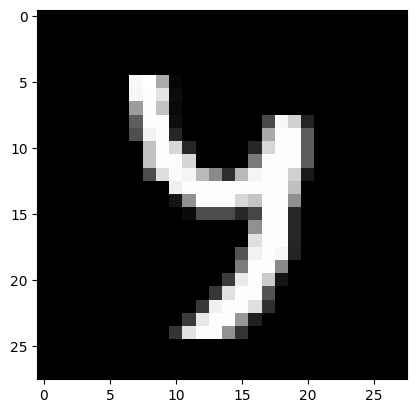

Predictions:  4


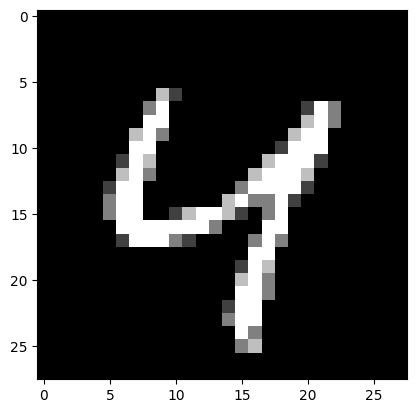

Predictions:  3


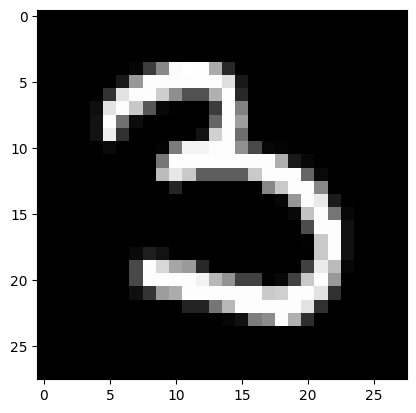

Predictions:  9


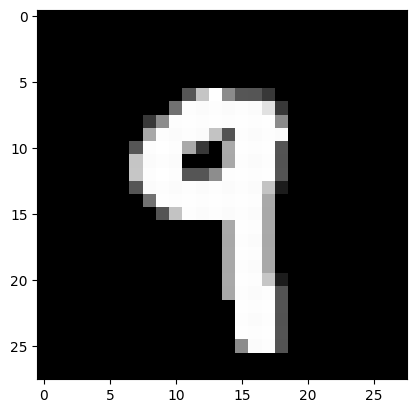

Predictions:  9


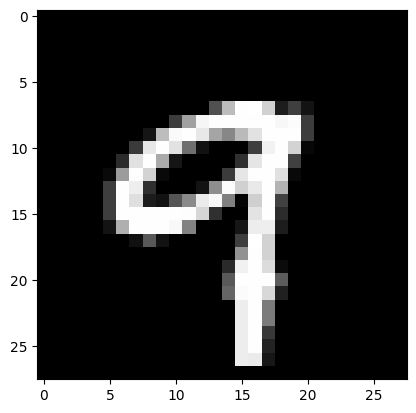

Predictions:  1


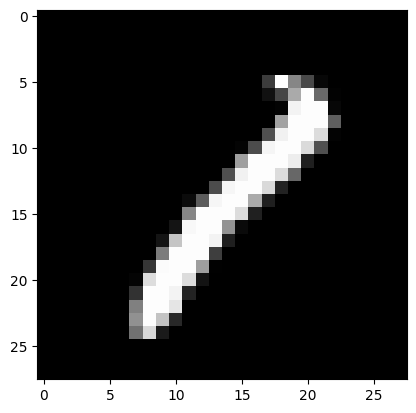

Predictions:  7


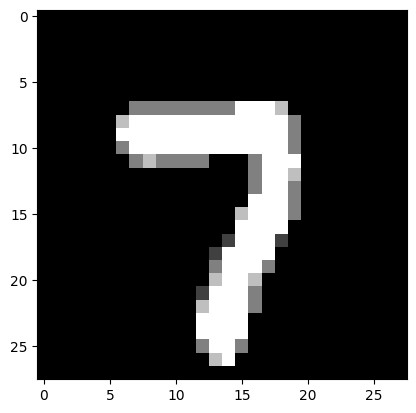

Predictions:  2


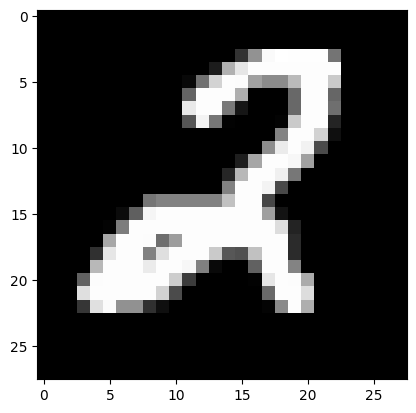

Predictions:  7


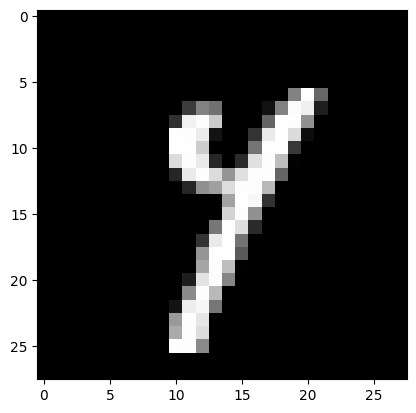

Predictions:  7


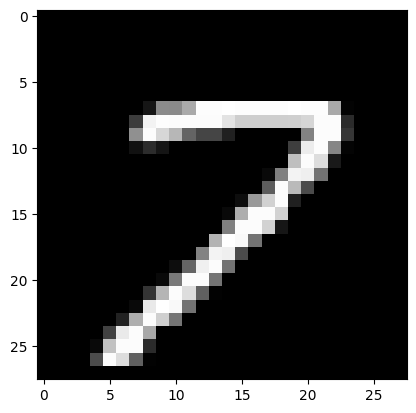

Predictions:  4


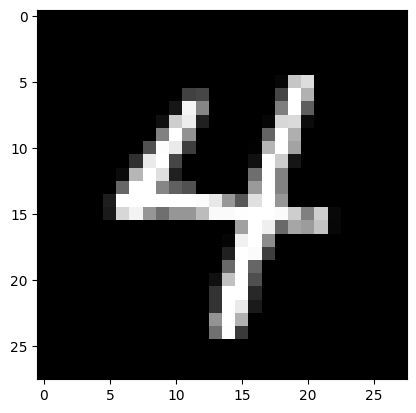

Predictions:  6


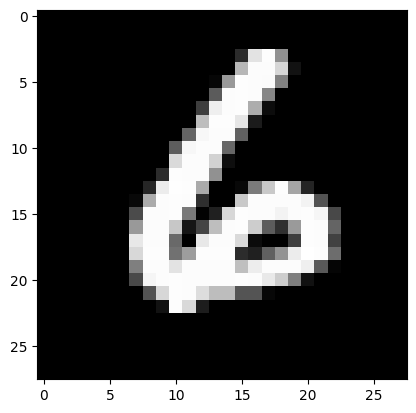

Predictions:  8


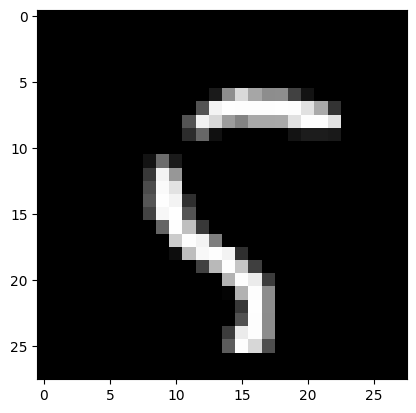

Predictions:  3


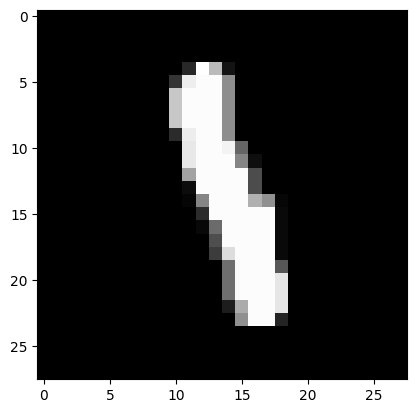

Predictions:  7


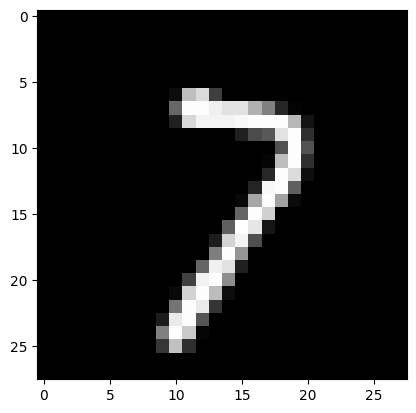

Predictions:  4


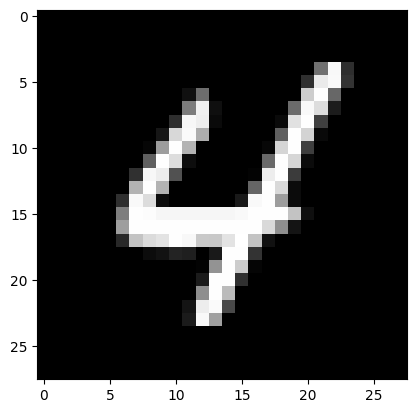

Predictions:  8


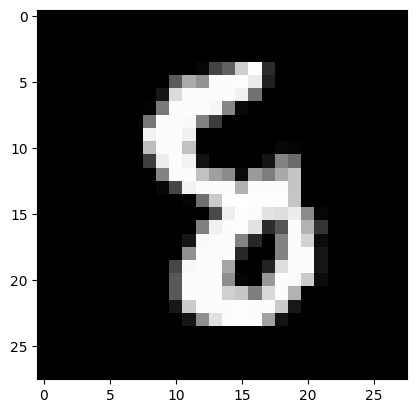

Predictions:  8


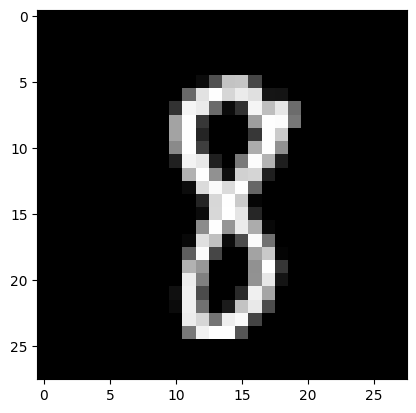

Predictions:  6


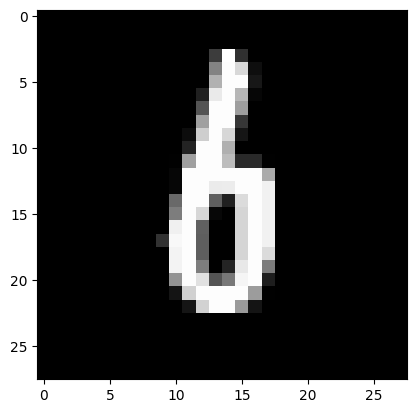

Predictions:  6


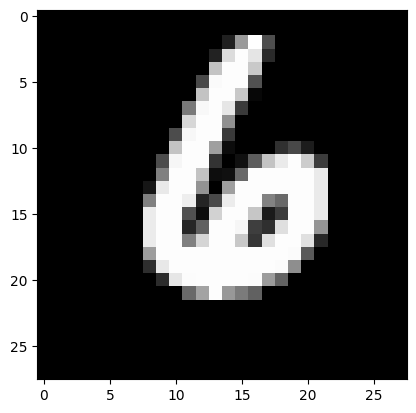

Predictions:  8


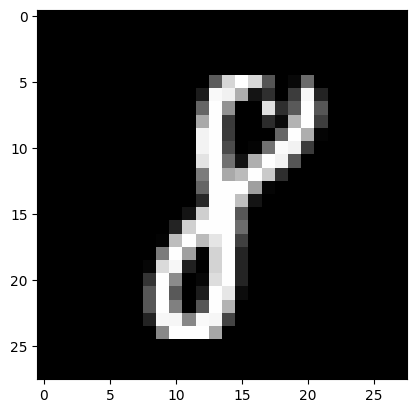

Predictions:  8


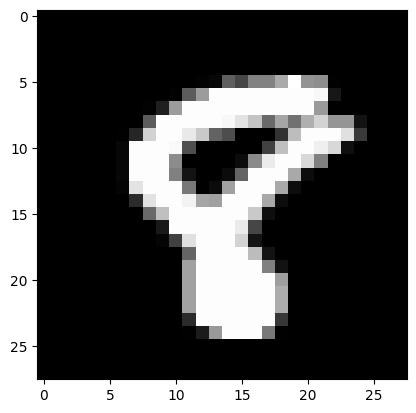

Predictions:  1


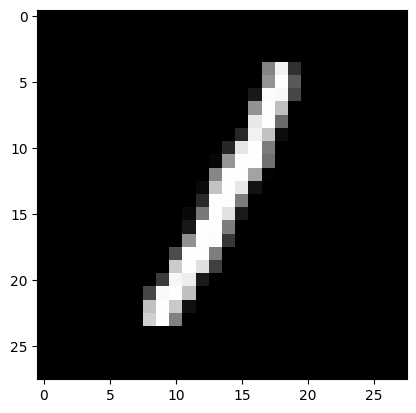

Predictions:  1


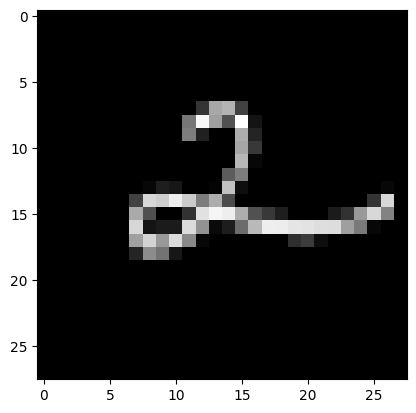

Predictions:  4


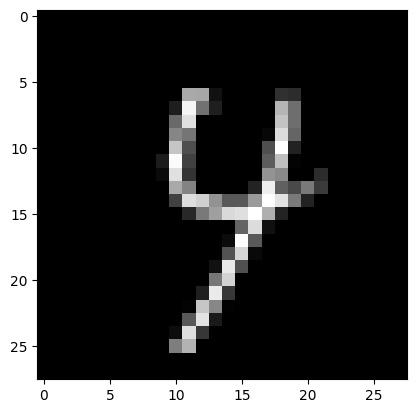

Predictions:  7


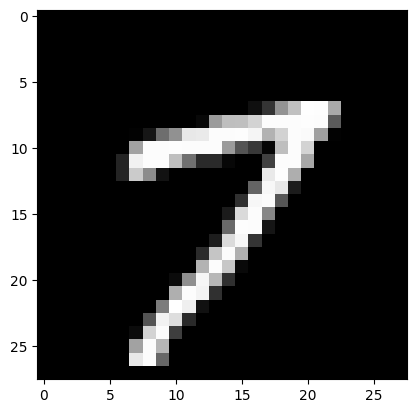

Predictions:  0


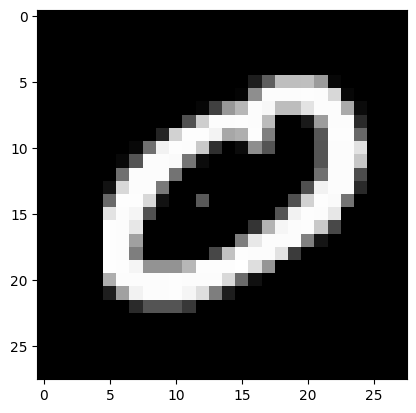

Predictions:  1


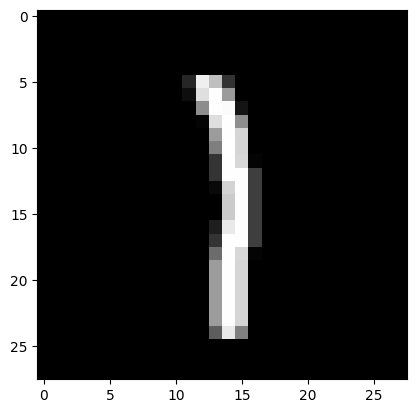

Predictions:  0


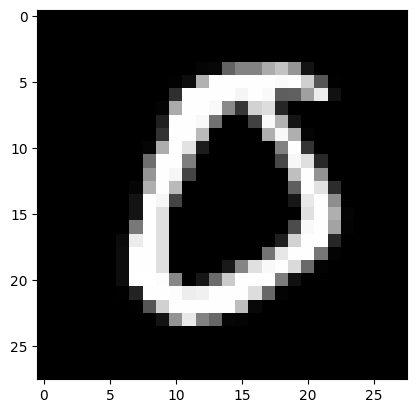

Predictions:  6


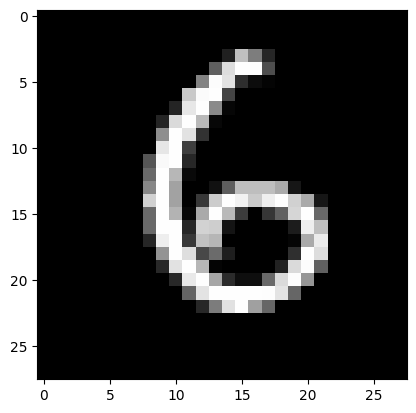

Predictions:  8


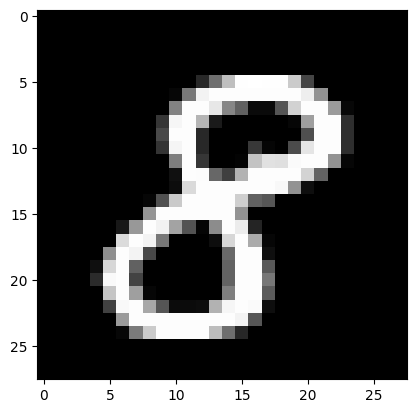

Predictions:  2


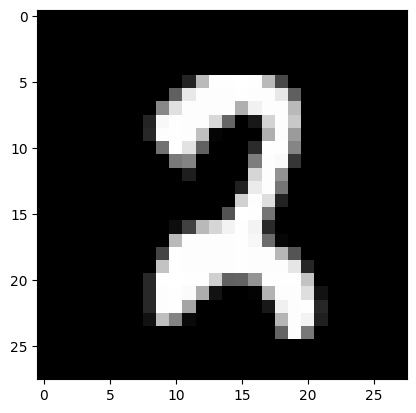

Predictions:  3


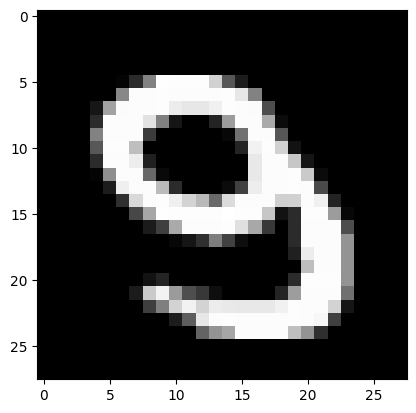

Predictions:  2


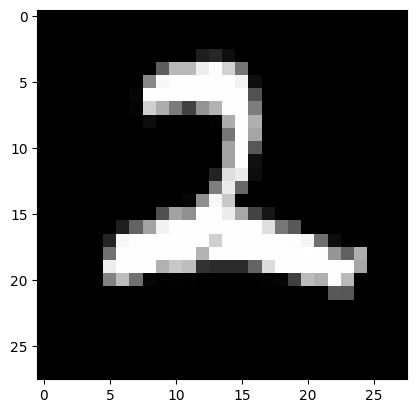

Predictions:  5


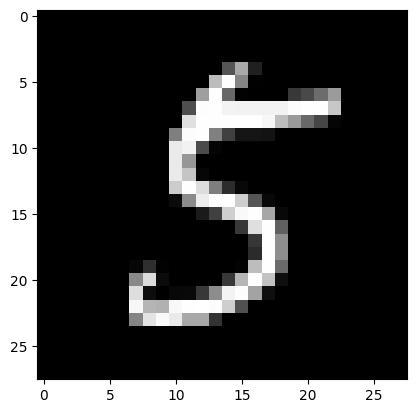

Predictions:  1


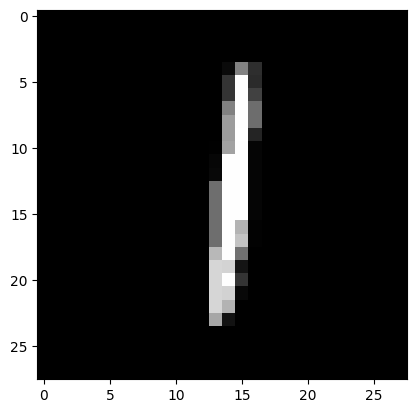

Predictions:  9


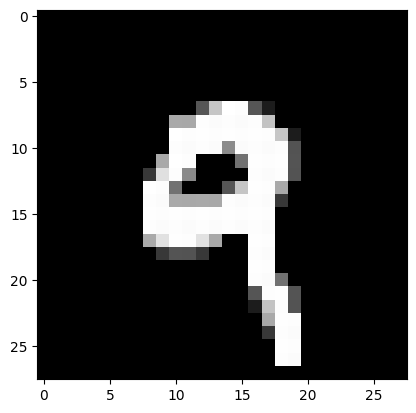

Predictions:  4


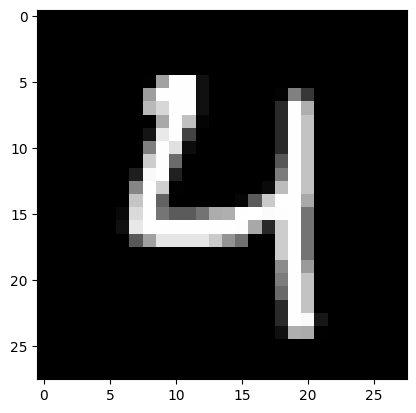

Predictions:  6


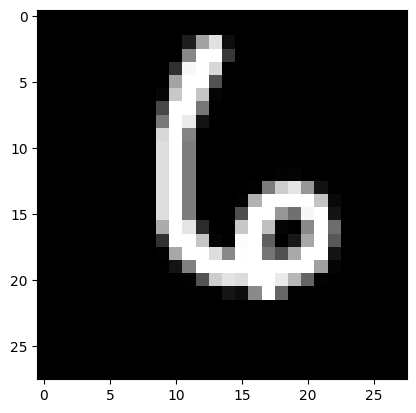

Predictions:  2


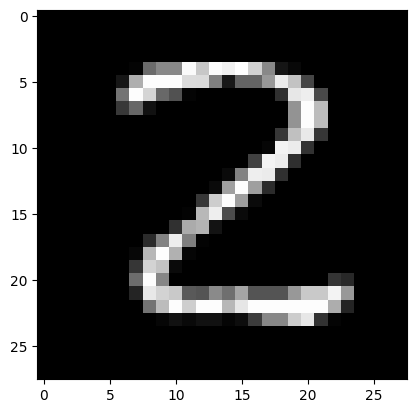

Predictions:  6


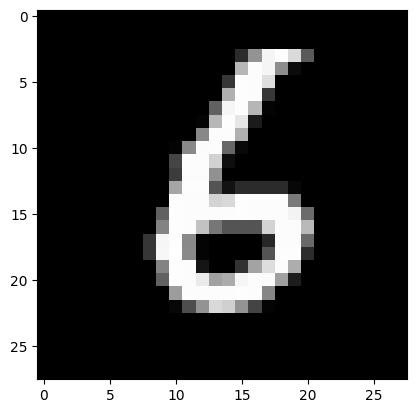

Predictions:  1


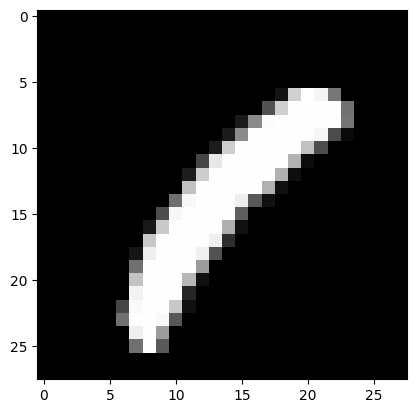

Predictions:  3


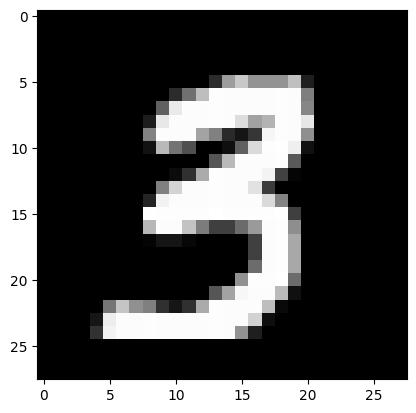

Predictions:  7


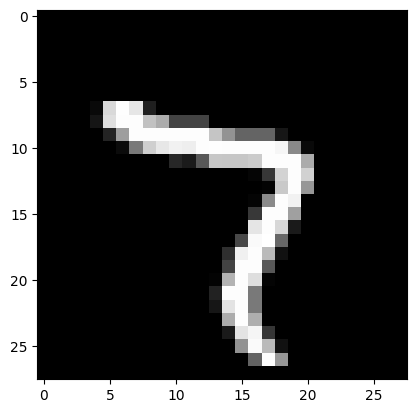

In [26]:
import matplotlib.pyplot as plt 
import numpy as np 

for i in range(0, 100, 2):
    print("Predictions: ", np.argmax(predictions[i]))
    
    shape =(28, 28)
    cmap = plt.get_cmap('gray')
    plt.imshow(np.reshape(test[i], shape), cmap=cmap)
    plt.show()

## **Evaluation**

In [27]:
bi_lstm.evaluate(X_val, Y_val, verbose=1)

350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8656 - loss: 0.4629


[0.4682900011539459, 0.8617857098579407]

In [28]:
Y_pred = bi_lstm.predict(X_val)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)
print(classification_report(Y_true, Y_pred_classes))

350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1116
           1       0.90      0.98      0.93      1244
           2       0.90      0.83      0.86      1094
           3       0.85      0.84      0.84      1185
           4       0.81      0.89      0.85      1073
           5       0.80      0.77      0.79      1035
           6       0.91      0.95      0.93      1111
           7       0.88      0.86      0.87      1163
           8       0.85      0.72      0.78      1080
           9       0.81      0.83      0.82      1099

    accuracy                           0.86     11200
   macro avg       0.86      0.86      0.86     11200
weighted avg       0.86      0.86      0.86     11200



Saving figure BiLSTM Confusion Matrix


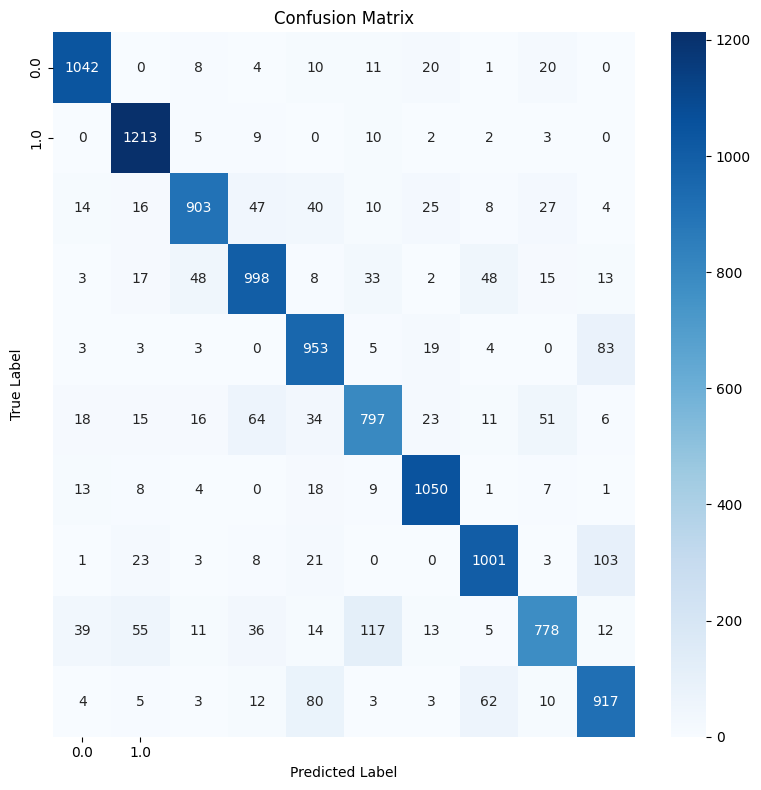

In [29]:
cm = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(Y_val), yticklabels=np.unique(Y_val))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
save_fig('BiLSTM Confusion Matrix')
plt.show()